# ETL & Data Processing

## 1. Set up

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
%pwd

'D:\\OneDrive\\w210\\capstone-project'

In [1]:
%cd ..
# %cd media/capstone-project

D:\OneDrive\w210\capstone-project


In [4]:
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

%matplotlib inline
sns.set_theme(color_codes=True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

In [4]:
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

In [5]:
spark

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 2. EDA

In [16]:
raw_data = pd.read_csv('data/top20_ddi/ddis_from_api_top20.csv', delimiter='\t')
# Filter out drug_pairs without SMILES data
raw_data = raw_data.dropna(subset=['smiles1', 'smiles2', 'd1_name', 'd2_name', 'interaction'], how='any')
raw_data = raw_data.drop_duplicates(('d1', 'd2'))

# Add a drug-pair column 
raw_data['d1_d2'] = raw_data.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
raw_data['drug_pair'] = raw_data.apply(lambda x: str(set(sorted([x['d1'], x['d2']]))), axis=1)

print('Raw data dimension:', raw_data.shape)
print('Number of distinct drugs in d1:', len(raw_data['d1'].unique()))
print('Number of distinct drugs in d2:', len(raw_data['d2'].unique()))
print('Number of distinct d1-d2 sequence:', len(raw_data['d1_d2'].unique()))
print('Number of distinct drug-pair:', len(raw_data['drug_pair'].unique()))
raw_data.head()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_50432\3025787181.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/top20_ddi/ddis_from_api_top20.csv', delimiter='\t')


Raw data dimension: (1400774, 11)
Number of distinct drugs in d1: 2415
Number of distinct drugs in d2: 2448
Number of distinct d1-d2 sequence: 1400774
Number of distinct drug-pair: 755017


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_d2,drug_pair
0,DB00006,DB00752,Bivalirudin,Tranylcypromine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1CC1C1=CC=CC=C1,"['DB00006', 'DB00752']","{'DB00752', 'DB00006'}"
1,DB00006,DB06228,Bivalirudin,Rivaroxaban,#Drug1 may increase the anticoagulant activities of #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,ClC1=CC=C(S1)C(=O)NC[C@H]1CN(C(=O)O1)C1=CC=C(C=C1)N1CCOCC1=O,"['DB00006', 'DB06228']","{'DB00006', 'DB06228'}"
2,DB00006,DB13946,Bivalirudin,Testosterone undecanoate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCCCCCCCCCC(=O)O[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C,"['DB00006', 'DB13946']","{'DB13946', 'DB00006'}"
3,DB00006,DB00605,Bivalirudin,Sulindac,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CC1=C(CC(O)=O)C2=CC(F)=CC=C2\C1=C/C1=CC=C(C=C1)S(C)=O,"['DB00006', 'DB00605']","{'DB00006', 'DB00605'}"
4,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCCCCCOC(=O)\N=C(\N)C1=CC=C(NCC2=NC3=C(C=CC(=C3)C(=O)N(CCC(=O)OCC)C3=NC=CC=C3)N2C)C=C1,"['DB00006', 'DB06695']","{'DB00006', 'DB06695'}"


In [21]:
raw_data = raw_data.astype({"interaction": str})
raw_data.interaction.dtype

dtype('O')

In [22]:
# Count the number of repeated pairs in the dataset
count_pair = dict(raw_data.d1_d2.value_counts())

# Display drug-pairs that have more than 1 interaction in the dataset
raw_data['count_pair'] = raw_data.d1_d2.map(count_pair)

pair_1count = len(raw_data[raw_data.count_pair == 1]['d1_d2'].unique())
pair_2count = len(raw_data[raw_data.count_pair > 1]['d1_d2'].unique())
print('Number of drug-pairs have 1 interaction:', pair_1count)
print('Number of drug-pairs have >1 interactions:', pair_2count)
# raw_data[raw_data.count_pair > 1].sort_values('d1_d2')

Number of drug-pairs have 1 interaction: 1400774
Number of drug-pairs have >1 interactions: 0


In [23]:
# Number of distinct Drugs in the dataset
all_drug_id = set(raw_data['d1'].unique()) | set(raw_data['d2'].unique())
print('Number of distinct drugs:', len(all_drug_id))

Number of distinct drugs: 2448


In [17]:
master_df = raw_data.copy()

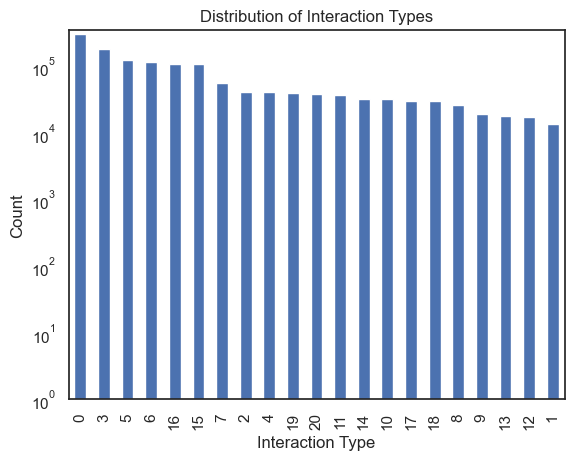

In [26]:
master_df['interaction_type'].value_counts().plot(kind='bar', logy=True)
sns.set_style('white')

plt.ylabel('Count')
plt.xlabel('Interaction Type')
plt.title('Distribution of Interaction Types')
labels = list(range(0, 21, 1))
plt.xticks(labels)
plt.ylim(bottom=1) 
plt.show()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_30560\4047289739.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=master_df, x='interaction_type', bins = 21, alpha=1, palette='cool_r')


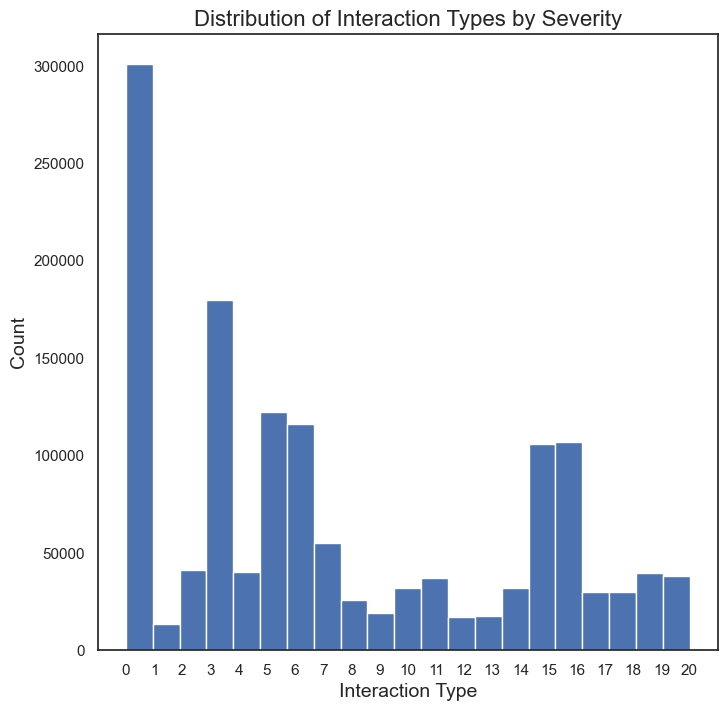

In [29]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
# sns.histplot(data=master_df, x='interaction_type', bins = 30, alpha=1, hue="severity", multiple="stack", palette='cool_r')
sns.histplot(data=master_df, x='interaction_type', bins = 21, alpha=1, palette='cool_r')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Interaction Type', fontsize=14)
plt.title('Distribution of Interaction Types by Severity', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 21, 1))
plt.xticks(labels)
plt.show()

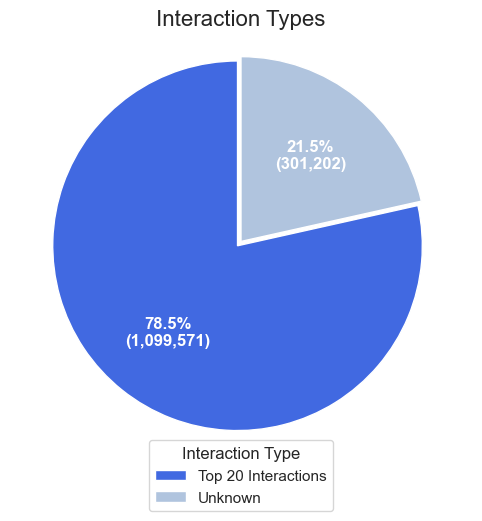

In [30]:
data = [master_df[master_df['interaction_type'] != 0].shape[0], master_df[master_df['interaction_type'] == 0].shape[0]]
labels = ['Top 20 Interactions', 'Unknown']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Interaction Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1)
         )

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Interaction Types", fontsize=16, y=0.95)
plt.show()

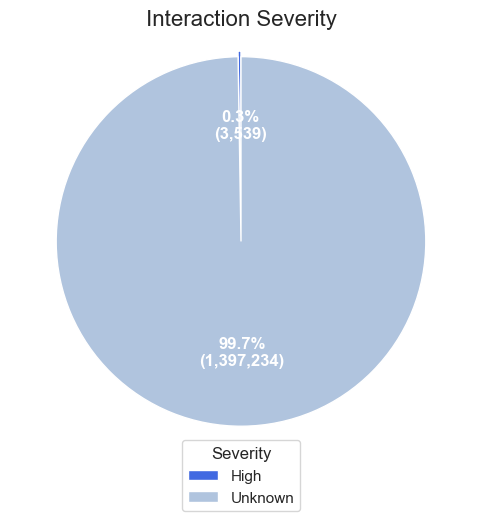

In [31]:
data = [master_df[master_df['severity'] == 'high'].shape[0], master_df[master_df['severity'] != 'high'].shape[0]]
labels = ['High', 'Unknown']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Severity",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Interaction Severity", fontsize=16, y=0.95)
plt.show()

In [33]:
# Save new interaction_information
interaction_df = master_df[['interaction_type', 'interaction']]
interaction_df['interaction'] = np.where(interaction_df['interaction_type'] != 0, interaction_df['interaction'], 'Unknown')
interaction_df = interaction_df.drop_duplicates().sort_values('interaction_type')
interaction_df.reset_index(inplace=True)
interaction_df = interaction_df.drop('index', axis=1)
interaction_df

C:\Users\ltmai\AppData\Local\Temp\ipykernel_30560\3248105686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_df['interaction'] = np.where(interaction_df['interaction_type'] != 0, interaction_df['interaction'], 'Unknown')


,interaction_type,interaction
0,0,Unknown
1,1,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.
2,2,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.
3,3,The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.
4,4,The therapeutic efficacy of #Drug2 can be decreased when used in combination with #Drug1.
5,5,#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.
6,6,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.
7,7,The risk or severity of QTc prolongation can be increased when #Drug1 is combined with #Drug2.
8,8,The risk or severity of methemoglobinemia can be increased when #Drug1 is combined with #Drug2.
9,9,#Drug2 may increase the excretion rate of #Drug1 which could result in a lower serum level and potentially a reduction in efficacy.


In [34]:
# save the dataframe to csv file
interaction_df.to_csv('data/top20_ddi/interaction_information_top20.csv', index=False, sep='\t')

## 5. Train / Test Split

In [19]:
master_df.drop('d1_d2', axis=1, inplace=True)
master_df.drop('drug_pair', axis=1, inplace=True)
master_df.drop('count_pair', axis=1, inplace=True)
master_df.head(2)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00006,DB00752,Bivalirudin,Tranylcypromine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1CC1C1=CC=CC=C1
1,DB00006,DB06228,Bivalirudin,Rivaroxaban,#Drug1 may increase the anticoagulant activities of #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,ClC1=CC=C(S1)C(=O)NC[C@H]1CN(C(=O)O1)C1=CC=C(C=C1)N1CCOCC1=O


In [21]:
# ## Extract Bit in the Approved Group
# drug_info_df = pd.read_csv('data/scraping_drug_info.csv', delimiter='\t')
# approved_drugs = drug_info_df[drug_info_df["approved_drug"] == 1]["drug_id"].values
# not_approved_drugs = drug_info_df[drug_info_df["approved_drug"] == 0]["drug_id"].values
# print("Number of approved drugs:", len(approved_drugs))
# print("Number of not approved drugs:", len(not_approved_drugs))
#
# # Extract DDI for approved drugs for train set
# not_approved_df = master_df[master_df["d1"].isin(not_approved_drugs) | master_df["d2"].isin(not_approved_drugs)]
# approved_df = master_df[master_df["d1"].isin(approved_drugs) & master_df["d2"].isin(approved_drugs)]
# print("Approved drugs DDIS: ", approved_df.shape)
# print("Not Approved Drugs DDIS: ", not_approved_df.shape)

## Extract Bit in the Approved Group
drug_info_df = pd.read_csv('data/drug_info_smiles_pathway.csv', delimiter='\t')
approved_drugs = drug_info_df[drug_info_df["approved_drug"] == 1]["drug_id"].values
not_approved_drugs = drug_info_df[drug_info_df["approved_drug"] != 1]["drug_id"].values
print("Number of approved drugs:", len(approved_drugs))
print("Number of not approved drugs:", len(not_approved_drugs))

drug_info_df.head(2)


Number of approved drugs: 2040
Number of not approved drugs: 527


,drug_id,generic_name,SMILES,drug_summary,brand_names,type,groups,weight,chemical_formula,synonyms,indication,conditions,pharmacodynamics,mechanism_of_action,target,protein_binding,metabolism,half_life,clearance,metabolism_pathway,UNII,CAS,approved_drug,pathway,smiles_pathway
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,Bivalirudin is a direct thrombin inhibitor used to treat heparin-induced thrombocytopenia and to prevent thrombosis during percutaneous coronary intervention.,Angiomax,Small Molecule,"Approved, Investigational",Average: 2180.2853 Monoisotopic: 2178.985813062,C98H138N24O33,Bivalirudin | Bivalirudina | Bivalirudinum,"For treatment of heparin-induced thrombocytopenia and for the prevention of thrombosis. Bivalirudin is indicated for use in patients undergoing percutaneous coronary intervention (PCI), in patient...",Thrombosis,Bivalirudin mediates an inhibitory action on thrombin by directly and specifically binding to both the catalytic site and anion-binding exosite of circulating and clot-bound thrombin. The action o...,"Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding exosite. Thrombin is a serine proteinase that plays a central role in the thrombotic process, acting ...","Category: A, Protein: Prothrombin, Actions: inhibitor","Other than thrombin and red blood cells, bivalirudin does not bind to plasma proteins.",Not Available,Normal renal function: 25 min (in normal conditions) | Creatinine clearance 10-29mL/min: 57min | Dialysis-dependant patients: 3.5h,"Category: A, Protein: Prothrombin, Actions: inhibitor",Not Available,TN9BEX005G,128270-60-0,1,bivalirudin is a new direct thrombin inhibitor approved by the food and drug administration for the treatment of deep vein thrombosis in patients who can not take unfractionated or low weight hepa...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CCC(=...,"Leuprolide is a peptide-based GnRH receptor superagonist used for the palliative treatment of prostate cancer, uterine leiomyomata, endometriosis, and central precocious puberty.","Camcevi, Eligard, Fensolvi, Lupaneta Pack 1-month, Lupron, Lupron Depot-ped, Viadur, Zeulide Depot",Small Molecule,"Approved, Investigational",Average: 1209.3983 Monoisotopic: 1208.645462232,C59H84N16O12,Leuprorelin | Leuprorelina | Leuproreline | Leuprorelinum,"Leuprolide is indicated for the treatment of advanced prostate cancer 6,12 and as palliative treatment of advanced prostate cancer.9 It is also used for the treatment of pediatric patients with ce...",Advanced Prostate Cancer | Anemia | Central Precocious Puberty (CPP) | Endometriosis,"Leuprolide is a gonadotropin-releasing hormone (GnRH) analogue that functions as a GnRH receptor superagonist.3,4 After an initial spike in GnRH-mediated steroidal production, including testostero...",Gonadotropin-releasing hormone (GnRH) is a naturally occurring decapeptide that modulates the hypothalamic-pituitary-gonadal (HPG) axis. GnRH binds to corresponding receptors (GnRHRs) on the anter...,"Category: A, Protein: Gonadotropin-releasing hormone receptor, Actions: agonist","Leuprolide displays in vitro binding to human plasma proteins between 43% and 49%.5,6,7,8,9,10,12",Not Available,"Leuprolide has a terminal elimination half-life of approximately three hours.5,6,7,8,9,10,12","Category: A, Protein: Gonadotropin-releasing hormone receptor, Actions: agonist",Not Available,EFY6W0M8TG,53714-56-0,1,gonadotropin-releasi

In [22]:
drug_info_df['smiles_pathway'][0]

'CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1C bivalirudin is a new direct thrombin inhibitor approved by the food and drug administration for the treatment of deep vein thrombosis in patients who can not take unfractionated or low weight heparin . n it does not need co - antithrobin to be effective and it is not associated with an increased risk of bleeding or thrombotic complications such as thrombus formation or cardiac arrhythmias.inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding exosite. thrombin is a serine proteinase that plays a central role in the thrombotic process acting to cleave fibrinogen into'

In [23]:
## Add Target and Mechanism of Action to Master DataFrame
target_df = drug_info_df[["drug_id", "smiles_pathway"]]

# Drug 1 merging
master_df2 = pd.merge(master_df, target_df, left_on="d1", right_on="drug_id", how="left")
master_df2 = master_df2.rename(columns={"smiles_pathway": "d1_smiles_pathway"})

# Drug 2 merging
master_df2 = pd.merge(master_df2, target_df, left_on="d2", right_on="drug_id", how="left")
master_df2 = master_df2.rename(columns={"smiles_pathway": "d2_smiles_pathway"})
master_df2 = master_df2.drop(["drug_id_x", "drug_id_y"], axis=1)
print('Number of missing values:\n', master_df2.isnull().sum())

master_df2["smiles_pathway_features"] = master_df2["d1_smiles_pathway"] + " [SEP] " + master_df2["d2_smiles_pathway"]

master_df2.head(5)

Number of missing values:
 d1                         0
d2                         0
d1_name                    0
d2_name                    0
interaction                0
interaction_type           0
severity             1397235
smiles1                    0
smiles2                    0
d1_smiles_pathway          0
d2_smiles_pathway          0
dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_smiles_pathway,d2_smiles_pathway,smiles_pathway_features
0,DB00006,DB00752,Bivalirudin,Tranylcypromine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1CC1C1=CC=CC=C1,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1CC1C1=CC=CC=C1 tranylcypromine irreversibly and nonselectively inhibits monoamine oxidase mao. within neurons mao appears to regulate the levels of monoamines released upon synaptic firing. sin...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...
1,DB00006,DB06228,Bivalirudin,Rivaroxaban,#Drug1 may increase the anticoagulant activities of #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,ClC1=CC=C(S1)C(=O)NC[C@H]1CN(C(=O)O1)C1=CC=C(C=C1)N1CCOCC1=O,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,ClC1=CC=C(S1)C(=O)NC[C@H]1CN(C(=O)O1)C1=CC=C(C=C1)N1CCOCC1=O rivaroxaban competitively inhibits free and clot bound factor xa. factor xa is needed to activate prothrombin factor ii to thrombin fac...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...
2,DB00006,DB13946,Bivalirudin,Testosterone undecanoate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCCCCCCCCCC(=O)O[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCCCCCCCCCC(=O)O[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C testosterone is a critical male sex hormone that is responsible for the normal growth and development of the male sex orga...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...
3,DB00006,DB00605,Bivalirudin,Sulindac,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CC1=C(CC(O)=O)C2=CC(F)=CC=C2\C1=C/C1=CC=C(C=C1)S(C)=O,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CC1=C(CC(O)=O)C2=CC(F)=CC=C2\C1=C/C1=CC=C(C=C1)S(C)=O asoril is an anti - inflammatory drug that is typically used to treat pain or rheumatoid arthritis associated conditions . n it inhibits prost...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N

In [25]:
# master_df2['severity'].fillna('Unknown')
master_df2.head(1)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_smiles_pathway,d2_smiles_pathway,smiles_pathway_features
0,DB00006,DB00752,Bivalirudin,Tranylcypromine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1CC1C1=CC=CC=C1,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1CC1C1=CC=CC=C1 tranylcypromine irreversibly and nonselectively inhibits monoamine oxidase mao. within neurons mao appears to regulate the levels of monoamines released upon synaptic firing. sin...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...


In [26]:
# Extract DDI for approved drugs for train set
not_approved_df = master_df2[master_df2["d1"].isin(not_approved_drugs) | master_df2["d2"].isin(not_approved_drugs)]
approved_df = master_df2[master_df2["d1"].isin(approved_drugs) & master_df2["d2"].isin(approved_drugs)]
print("Approved drugs DDIS: ", approved_df.shape)
print("Not Approved Drugs DDIS: ", not_approved_df.shape)

Approved drugs DDIS:  (1142233, 12)
Not Approved Drugs DDIS:  (258541, 12)


In [37]:
print(approved_drugs[:10])
not_approved_drugs[:10]

['DB00006' 'DB00007' 'DB00014' 'DB00027' 'DB00035' 'DB00067' 'DB00080'
 'DB00091' 'DB00115' 'DB00118']


array(['DB00127', 'DB00155', 'DB00168', 'DB00212', 'DB00232', 'DB00269',
       'DB00453', 'DB00463', 'DB00505', 'DB00546'], dtype=object)

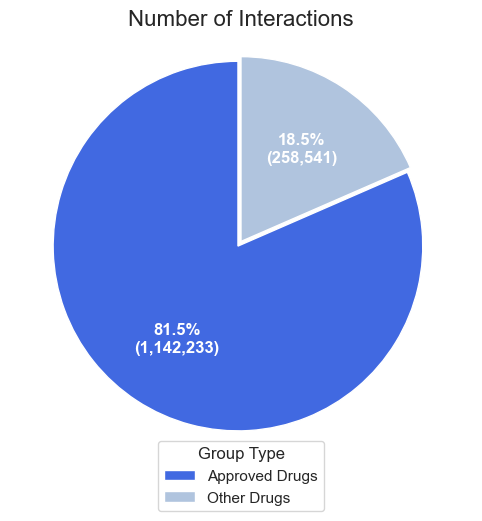

In [44]:
data = [approved_df.shape[0], not_approved_df.shape[0]]
labels = ['Approved Drugs', 'Other Drugs']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Group Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Number of Interactions", fontsize=16, y=0.95)
plt.show()

In [27]:
# Save Not Approved Drugs for test set
val_test_drug_split = round(len(not_approved_drugs)/2)
np.random.shuffle(not_approved_drugs)
val_drugs = not_approved_drugs[:val_test_drug_split]

val_df = not_approved_df[not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs)]
test_df = not_approved_df[~(not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs))]

val_df = val_df.sample(frac=1, random_state=42)
val_df = val_df.reset_index()
val_df = val_df.drop('index', axis=1)
test_df = test_df.sample(frac=1, random_state=42)
test_df = test_df.reset_index()
test_df = test_df.drop('index', axis=1)

# Save test set
# save the dataframe to csv file
# not_approved_df.to_csv('data/ddi_test_api.csv', index=False)

C:\Users\ltmai\AppData\Local\Temp\ipykernel_50432\2508564974.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = not_approved_df[not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs)]
C:\Users\ltmai\AppData\Local\Temp\ipykernel_50432\2508564974.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = not_approved_df[~(not_approved_df["d1"].isin(val_drugs) | master_df["d2"].isin(val_drugs))]


In [28]:
print('Test dataset shape:', test_df.shape)
print('Number of interaction types in test set:', len(test_df.interaction_type.unique()))
print('Interaction type distribution in test set, Bottom 10:')
print(test_df.interaction_type.value_counts()[-10:])
test_df = test_df[["d1", "d2", "smiles1", "smiles2", "smiles_pathway_features", "interaction_type", "severity"]]
test_df.head(1)

Test dataset shape: (208540, 12)
Number of interaction types in test set: 21
Interaction type distribution in test set, Bottom 10:
6     5320
9     4056
12    3921
17    3309
1     3130
14    2784
18    2770
10    2690
8     2348
13    2010
Name: interaction_type, dtype: int64


,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
0,DB00305,DB11616,[H][C@]12CN3C4=C([C@@H](COC(N)=O)[C@@]3(OC)[C@@]1([H])N2)C(=O)C(N)=C(C)C4=O,[H][C@]1(N)C[C@]([H])(O[C@@]2([H])C[C@@](O)(CC3=C(O)C4=C(C(O)=C23)C(=O)C2=C(C=CC=C2OC)C4=O)C(=O)CO)O[C@@]([H])(C)[C@@]1([H])O[C@]1([H])CCCCO1,[H][C@]12CN3C4=C([C@@H](COC(N)=O)[C@@]3(OC)[C@@]1([H])N2)C(=O)C(N)=C(C)C4=O mitomycin is activated in vivo to a bifunctional and trifunctional alkylating agent. binding to dna leads to cross-linki...,3,NaN


In [29]:
test_df.head(1)
print('Validation dataset shape:', val_df.shape)
print('Number of interaction types in Validation set:', len(val_df.interaction_type.unique()))
print('Interaction type distribution in Validation set, Bottom 10:')
print(val_df.interaction_type.value_counts()[-10:])
val_df = val_df[["d1", "d2", "smiles1", "smiles2", "smiles_pathway_features", "interaction_type", "severity"]]
val_df.head(1)

Validation dataset shape: (50001, 12)
Number of interaction types in Validation set: 21
Interaction type distribution in Validation set, Bottom 10:
7     1566
1     1296
13    1045
12     993
14     762
18     751
17     692
10     692
8      517
9      461
Name: interaction_type, dtype: int64


,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
0,DB11951,DB04818,CC1=NC=C(OC[C@]2(C[C@H]2C(=O)NC2=NC=C(F)C=C2)C2=CC=CC(F)=C2)C(C)=N1,CC(C)NNC(=O)C1=CC=NC=C1,CC1=NC=C(OC[C@]2(C[C@H]2C(=O)NC2=NC=C(F)C=C2)C2=CC=CC(F)=C2)C(C)=N1 the orexin neuropeptide signaling system is involved in many physiologic functions including sleep/wake control. orexin-a and or...,3,NaN


In [30]:
approved_df = approved_df.sample(frac=1, random_state=42)
approved_df = approved_df.reset_index()
approved_df = approved_df.drop('index', axis=1)

print('Training dataset shape:', approved_df.shape)
print('Number of interaction types in Validation set:', len(approved_df.interaction_type.unique()))
print('Interaction type distribution in Validation set, Bottom 10:')
print(approved_df.interaction_type.value_counts()[-10:])

approved_df = approved_df[["d1", "d2", "smiles1", "smiles2", "smiles_pathway_features", "interaction_type", "severity"]]
approved_df.head(1)

Training dataset shape: (1142233, 12)
Number of interaction types in Validation set: 21
Interaction type distribution in Validation set, Bottom 10:
19    28288
20    28253
18    26136
17    26013
11    24461
8     23183
13    14709
9     14677
12    12338
1      9097
Name: interaction_type, dtype: int64


,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
0,DB06708,DB00476,CCCCN(CCCC)CC(O)C1=C2C(=CC(Cl)=C1)\C(=C/C1=CC=C(Cl)C=C1)C1=C2C=CC(Cl)=C1,CNCC[C@H](OC1=CC=CC2=CC=CC=C12)C1=CC=CS1,CCCCN(CCCC)CC(O)C1=C2C(=CC(Cl)=C1)\C(=C/C1=CC=C(Cl)C=C1)C1=C2C=CC(Cl)=C1 the exact mechanism by which lumefantrine exerts its antimalarial effect is unknown. however available data suggest that lu...,16,NaN


In [10]:
# save the dataframe to csv file
test_df.to_csv('data/top20_ddi/ddi_test_top20.csv', index=False, sep='\t')
val_df.to_csv('data/top20_ddi/ddi_val_top20.csv', index=False, sep='\t')
approved_df.to_csv('data/top20_ddi/ddi_train_top20.csv', index=False, sep='\t')

In [6]:
approved_df = pd.read_csv('data/top20_ddi/ddi_train_top20.csv', sep='\t')

In [9]:
# approved_df = approved_df[["d1", "d2", "smiles1", "smiles2", "smiles_pathway_features", "interaction_type", "severity"]]
approved_df.head(5)

,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
0,DB06708,DB00476,CCCCN(CCCC)CC(O)C1=C2C(=CC(Cl)=C1)\C(=C/C1=CC=C(Cl)C=C1)C1=C2C=CC(Cl)=C1,CNCC[C@H](OC1=CC=CC2=CC=CC=C12)C1=CC=CS1,CCCCN(CCCC)CC(O)C1=C2C(=CC(Cl)=C1)\C(=C/C1=CC=C(Cl)C=C1)C1=C2C=CC(Cl)=C1 the exact mechanism by which lumefantrine exerts its antimalarial effect is unknown. however available data suggest that lu...,16,NaN
1,DB09082,DB01108,OCC1=C(O)C=CC(=C1)[C@@H](O)CNCCCCCCOCCOCC1=C(Cl)C=CC=C1Cl,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]23O[C@@H]2C(O)=C(C[C@]13C)C#N,OCC1=C(O)C=CC(=C1)[C@@H](O)CNCCCCCCOCCOCC1=C(Cl)C=CC=C1Cl vilanterol is a selective long-acting beta2-adrenergic agonist. its pharmacological effect is attributable to stimulation of intracellular...,3,NaN
2,DB09089,DB00716,CCC(COC(=O)C1=CC(OC)=C(OC)C(OC)=C1)(N(C)C)C1=CC=CC=C1,CCCC1=C2N(CC)C(=CC(=O)C2=CC2=C1OC(=CC2=O)C(O)=O)C(O)=O,CCC(COC(=O)C1=CC(OC)=C(OC)C(OC)=C1)(N(C)C)C1=CC=CC=C1 at high concentrations trimebutine is shown to inhibit the extracellular ca2+ influx in the smooth muscle cells through voltage dependent l-ty...,5,NaN
3,DB00433,DB13595,CN1CCN(CCCN2C3=CC=CC=C3SC3=C2C=C(Cl)C=C3)CC1,O.[Mg++].[Al+3].[Al+3].[O-][Si]([O-])([O-])[O-].[O-][Si]([O-])([O-])[O-],CN1CCN(CCCN2C3=CC=CC=C3SC3=C2C=C(Cl)C=C3)CC1 the mechanism of action of prochlorperazine has not been fully determined but may be primarily related to its anti-dopaminergic effects. prochlorperazi...,0,NaN
4,DB08882,DB01208,CC#CCN1C(=NC2=C1C(=O)N(CC1=NC3=C(C=CC=C3)C(C)=N1)C(=O)N2C)N1CCC[C@@H](N)C1,C[C@H]1CN(C[C@@H](C)N1)C1=C(F)C(N)=C2C(=O)C(=CN(C3CC3)C2=C1F)C(O)=O,CC#CCN1C(=NC2=C1C(=O)N(CC1=NC3=C(C=CC=C3)C(C)=N1)C(=O)N2C)N1CCC[C@@H](N)C1 linagliptin is a competitive reversible dpp-4 inhibitor. inhibition of this enzyme slows the breakdown of glp-1 and gluco...,0,NaN


## 6. Under-Sampling & Up-Sampling

In [11]:
print('Training set label distribution:')
# approved_df = approved_df[["d1", "d2", "interaction_type", "severity"]]
approved_df.interaction_type.value_counts()

Training set label distribution:


0     232697
3     125426
6     108640
5     108509
16     96423
15     96362
7      48208
4      30934
2      30934
10     28473
14     28472
19     28288
20     28253
18     26136
17     26013
11     24461
8      23183
13     14709
9      14677
12     12338
1       9097
Name: interaction_type, dtype: int64

C:\Users\ltmai\AppData\Local\Temp\ipykernel_30560\2002260618.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=approved_df, x='interaction_type', bins = 21, alpha=1, palette='cool_r', stat='density')


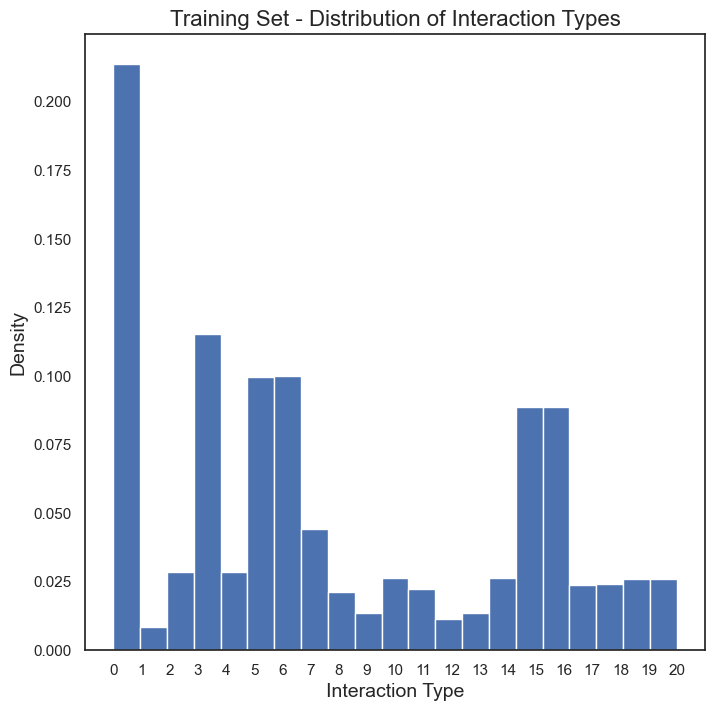

In [52]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=approved_df, x='interaction_type', bins = 21, alpha=1, palette='cool_r', stat='density')
plt.ylabel('Density', fontsize=14)
plt.xlabel('Interaction Type', fontsize=14)
plt.title('Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 21, 1))
plt.xticks(labels)
plt.show()

In [13]:
from sklearn.utils import resample

def balance_dataset(df, n_samples=10000, random_state=42):
    label_counts = df.interaction_type.value_counts()

    ## Downsample Majority cClasses
    # Get majority classes (all labels >= n_samples)
    majority_classes = approved_df.interaction_type.value_counts() \
        [approved_df.interaction_type.value_counts() >= n_samples].index

    # Initialize
    df_majorities = pd.DataFrame(data=[],
                                 columns=["d1", "d2", "smiles1", "smiles2", "smiles_pathway_features", "interaction_type", "severity"])

    for i in range(len(majority_classes)):
        label = majority_classes[i]
        df_majority = df[df["interaction_type"] == label]
        df_downsample = resample(df_majority,
                                 replace=False,     # sample without replacement
                                 n_samples=n_samples,    # change majority to minority clas
                                 random_state=random_state)
        # Add each majority class to down_sample df:
        # Combine all downsampled majority classes
        df_majorities = pd.concat([df_majorities, df_downsample])


    ## Upsample Minority Classes
    # Get majority classes (all labels < n_samples)
    minority_classes = approved_df.interaction_type.value_counts() \
        [approved_df.interaction_type.value_counts() < n_samples].index

    # Initialize
    df_minorities = pd.DataFrame(data=[],
                                 columns=["d1", "d2", "smiles1", "smiles2", "smiles_pathway_features", "interaction_type", "severity"])

    for i in range(len(minority_classes)):
        label = minority_classes[i]
        df_minority = df[df["interaction_type"] == label]
        df_upsample = resample(df_minority,
                               replace=True,     # sample WITH replacement
                               n_samples=n_samples,    # change majority to minority clas
                               random_state=random_state)
        # Add each minority class to up-sample df:
        # Combine all Up-sampled minority classes
        df_minorities = pd.concat([df_minorities, df_upsample])

    ## Combine Upsample & Downsample data
    df = pd.concat([df_majorities, df_minorities])
    df = df.sample(frac=1, random_state=42)
    df = df.reset_index()
    df = df.drop('index', axis=1)

    return df

### Balance to have 15,000 each label

In [14]:
## Balance data with each label = 10,000 samples
balance_df_15k = balance_dataset(approved_df, n_samples=15000)
print(balance_df_15k.shape)
balance_df_15k.head(2)

(315000, 7)


,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
0,DB00468,DB01246,[H][C@]1(C[C@@H]2CC[N@]1C[C@@H]2C=C)[C@H](O)C1=CC=NC2=CC=C(OC)C=C12,CC(CN(C)C)CN1C2=CC=CC=C2SC2=CC=CC=C12,[H][C@]1(C[C@@H]2CC[N@]1C[C@@H]2C=C)[C@H](O)C1=CC=NC2=CC=C(OC)C=C12 the theorized mechanism of action for quinine and related anti-malarial drugs is that these drugs are toxic to the malaria paras...,7,NaN
1,DB09135,DB09281,CC(=O)N(CC(O)CO)C1=C(I)C(C(=O)NCC(O)CO)=C(I)C(C(=O)NCCO)=C1I,[Mg++].[Mg++].[O-][Si](=O)O[Si]([O-])([O-])O[Si]([O-])=O,CC(=O)N(CC(O)CO)C1=C(I)C(C(=O)NCC(O)CO)=C(I)C(C(=O)NCCO)=C1I intravascular injection results in opacification of vessels in the path of flow of the contrast medium permitting radiographic visualiz...,6,NaN


In [15]:
balance_df_15k.to_csv('data/top20_ddi/ddi_train_top20_balanced_15k.csv', index=False, sep='\t')

C:\Users\ltmai\AppData\Local\Temp\ipykernel_20196\126002509.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=balance_df_15k, x='interaction_type',bins = 87, alpha=1, palette='cool')


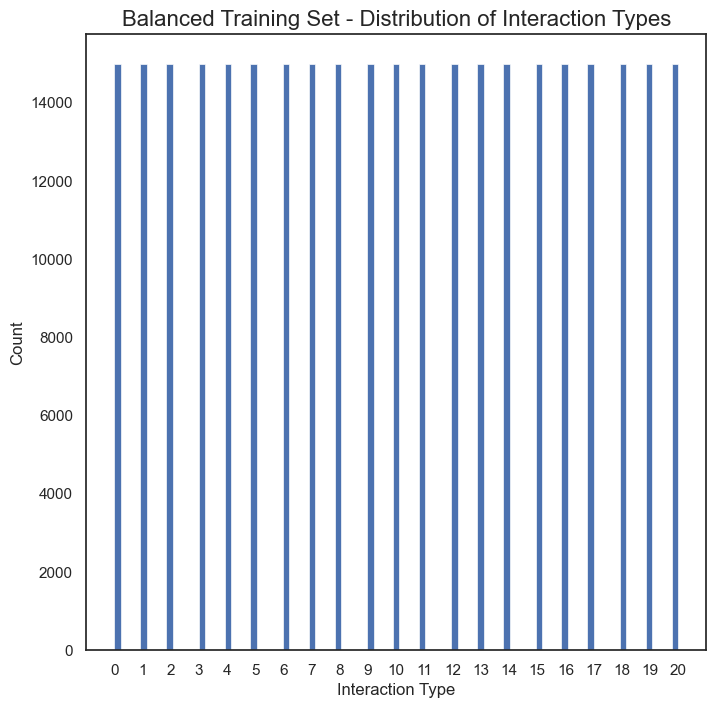

In [16]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=balance_df_15k, x='interaction_type',bins = 87, alpha=1, palette='cool')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Interaction Type', fontsize=12)
plt.title('Balanced Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(0, 21, 1))
plt.xticks(labels)
plt.show()